In [ ]:
!pip install transformers datasets scikit-learn pandas openpyxl


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding , TrainingArguments , Trainer
from datasets import Dataset
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import tempfile
import os


In [22]:
# Load the labeled data
df_labeled = pd.read_excel("DataLabel.xlsx")

# Clean and strip labels
df_labeled["label"] = df_labeled["label"].str.strip().str.title()

label_map = {"Complaint": 0, "Inquiry": 1, "Suggestion": 2, "Thank You": 3}
df_labeled["label"] = df_labeled["label"].map(label_map)
df_labeled.dropna(subset=["label"], inplace=True)

# Convert to integer
df_labeled["label"] = df_labeled["label"].astype(int)

df_labeled.dropna(subset=["text", "label"], inplace=True)
df_labeled = df_labeled[["text", "label"]]
df_labeled.head()
print(df_labeled['label'].unique())


[0 1 3 2]


In [21]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
dataset = Dataset.from_pandas(df_labeled)

# Tokenize
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Train/test split
train_test = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test["train"]
eval_dataset = train_test["test"]
import os
os.environ["WANDB_DISABLED"] = "true"

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [20]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=4)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=18,
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-20-2570182297.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [5]:
trainer.train()


Step,Training Loss
50,0.961300
100,0.172400
150,0.005100
200,0.002200
250,0.001700


TrainOutput(global_step=252, training_loss=0.22673955750429914, metrics={'train_runtime': 2612.653, 'train_samples_per_second': 0.551, 'train_steps_per_second': 0.096, 'total_flos': 63569295794352.0, 'train_loss': 0.22673955750429914, 'epoch': 18.0})

In [6]:
preds = trainer.predict(eval_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=label_map.keys()))


              precision    recall  f1-score   support

   Complaint       1.00      0.86      0.92         7
     Inquiry       0.86      0.75      0.80         8
  Suggestion       0.50      1.00      0.67         1
   Thank You       0.80      1.00      0.89         4

    accuracy                           0.85        20
   macro avg       0.79      0.90      0.82        20
weighted avg       0.88      0.85      0.85        20



In [7]:
os.environ["WANDB_DISABLED"] = "true"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load and clean the unlabeled data
df_unlabeled = pd.read_excel("DataUnlabel.xlsx")
df_unlabeled.dropna(subset=["text"], inplace=True)
texts = list(df_unlabeled["text"])
batch_size = 32

all_predictions = []
all_confidences = []

model.eval()

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        confidence, predictions = torch.max(probs, dim=1)

    all_predictions.extend(predictions.cpu().numpy())
    all_confidences.extend(confidence.cpu().numpy())

    del encodings, outputs, logits, probs, predictions, confidence
    torch.cuda.empty_cache()

# Add predictions to DataFrame
df_unlabeled["predicted_label"] = all_predictions
df_unlabeled["confidence"] = all_confidences

# Filter high-confidence predictions
df_pseudo = df_unlabeled[df_unlabeled["confidence"] > 0.90].copy()
df_pseudo["label"] = df_pseudo["predicted_label"].astype(int)

print(f"✅ Using {len(df_pseudo)} pseudo-labeled samples.")

# Combine with original labeled data
df_full = pd.concat([
    df_labeled[["text", "label"]],
    df_pseudo[["text", "label"]]
], ignore_index=True)

# Shuffle the dataset
df_full = df_full.sample(frac=1).reset_index(drop=True)


✅ Using 854 pseudo-labeled samples.


In [8]:
# Convert to HuggingFace Dataset
dataset_full = Dataset.from_pandas(df_full)

# Tokenize
tokenized_full = dataset_full.map(tokenize_function, batched=True)

# Train/test split again
train_test_full = tokenized_full.train_test_split(test_size=0.2)
train_dataset = train_test_full["train"]
eval_dataset = train_test_full["test"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Map:   0%|          | 0/954 [00:00<?, ? examples/s]

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [9]:
# Re-initialize the Trainer with the new datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

/tmp/ipython-input-9-791907189.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,0.626800
100,0.733500
150,0.472200
200,0.340600
250,0.459600
300,0.097800
350,0.240300
400,0.061300
450,0.053200
500,0.047800


Step,Training Loss
50,0.626800
100,0.733500
150,0.472200
200,0.340600
250,0.459600
300,0.097800
350,0.240300
400,0.061300
450,0.053200
500,0.047800


TrainOutput(global_step=2304, training_loss=0.07514773717617926, metrics={'train_runtime': 30351.8444, 'train_samples_per_second': 0.452, 'train_steps_per_second': 0.076, 'total_flos': 947033885366664.0, 'train_loss': 0.07514773717617926, 'epoch': 18.0})

In [10]:
# Evaluate the retrained model
preds = trainer.predict(eval_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=label_map.keys()))


              precision    recall  f1-score   support

   Complaint       0.95      0.91      0.93       106
     Inquiry       0.86      0.93      0.89        70
  Suggestion       1.00      0.89      0.94         9
   Thank You       1.00      1.00      1.00         6

    accuracy                           0.92       191
   macro avg       0.95      0.93      0.94       191
weighted avg       0.92      0.92      0.92       191



In [12]:
model.save_pretrained("Text_classifier_model")
tokenizer.save_pretrained("Text_classifier_model")


('Text_classifier_model/tokenizer_config.json',
 'Text_classifier_model/special_tokens_map.json',
 'Text_classifier_model/spm.model',
 'Text_classifier_model/added_tokens.json',
 'Text_classifier_model/tokenizer.json')

🔍 Predictions:

1. Text: I’m really unhappy with the service I received.
   → Predicted: Complaint | True: Complaint

2. Text: When will my package be delivered?
   → Predicted: Inquiry | True: Inquiry

3. Text: It would be nice to have more payment options.
   → Predicted: Suggestion | True: Suggestion

4. Text: Thank you for the quick support!
   → Predicted: Thank You | True: Thank You

5. Text: Why was my account deactivated without notice?
   → Predicted: Inquiry | True: Complaint

6. Text: Could you help me change my subscription plan?
   → Predicted: Suggestion | True: Inquiry

7. Text: I appreciate how responsive your team is.
   → Predicted: Thank You | True: Thank You

8. Text: Maybe you could add dark mode to the app?
   → Predicted: Suggestion | True: Suggestion

9. Text: Your service is the worst I’ve used so far.
   → Predicted: Complaint | True: Complaint

10. Text: Thanks! Everything works perfectly now.
   → Predicted: Thank You | True: Thank You


📊 Classification Rep

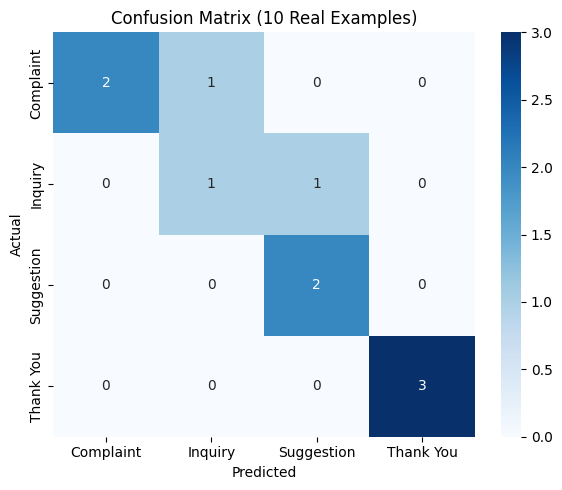

In [17]:
# Sample texts
texts = [
    "I’m really unhappy with the service I received.",
    "When will my package be delivered?",
    "It would be nice to have more payment options.",
    "Thank you for the quick support!",
    "Why was my account deactivated without notice?",
    "Could you help me change my subscription plan?",
    "I appreciate how responsive your team is.",
    "Maybe you could add dark mode to the app?",
    "Your service is the worst I’ve used so far.",
    "Thanks! Everything works perfectly now."
]

# True labels: 0 = Complaint, 1 = Inquiry, 2 = Suggestion, 3 = Thank You
true_labels = [0, 1, 2, 3, 0, 1, 3, 2, 0, 3]

label_map = {0: "Complaint", 1: "Inquiry", 2: "Suggestion", 3: "Thank You"}

# Inference function
def classify_text(text, model, tokenizer, device="cpu"):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    return pred_class

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predict and print per sample
predicted_labels = []
print("🔍 Predictions:\n")
for i, text in enumerate(texts):
    pred = classify_text(text, model, tokenizer, device)
    predicted_labels.append(pred)
    print(f"{i+1}. Text: {text}")
    print(f"   → Predicted: {label_map[pred]} | True: {label_map[true_labels[i]]}\n")

print("\n📊 Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=label_map.values()))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (10 Real Examples)")
plt.tight_layout()
plt.show()


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("Text_classifier_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("Text_classifier_model")
label_map = {0: "Complaint", 1: "Inquiry", 2: "Suggestion", 3: "Thank You"}

# Prediction
def classify_text_gr(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        conf = torch.max(probs).item()
    return f"{label_map[pred]} (Confidence: {conf:.2f})"

# Gradio interface
gr.Interface(
    fn=classify_text_gr,
    inputs=gr.Textbox(lines=4, placeholder="Enter a message..."),
    outputs="text",
    title="Text Classifier",
    description="Classifies a message as Complaint, Inquiry, Suggestion, or Thank You.",
    examples=[
        ["I want to cancel my order, it never arrived."],
        ["Can I get more information about my subscription?"],
        ["You should offer a mobile app."],
        ["Thank you so much for your fast response!"]
    ]
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://89d547407fc96abd12.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model + tokenizer once
model = AutoModelForSequenceClassification.from_pretrained("Text_classifier_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("Text_classifier_model")
label_map = {0: "Complaint", 1: "Inquiry", 2: "Suggestion", 3: "Thank You"}

def classify_reviews(df):
    texts = df["text"].fillna("").tolist()
    batch_size = 32
    predictions = []
    confidences = []

    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encodings = tokenizer(batch, truncation=True, padding=True, return_tensors="pt").to(device)
            outputs = model(**encodings)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            conf, preds = torch.max(probs, dim=1)
            predictions.extend(preds.cpu().numpy())
            confidences.extend(conf.cpu().numpy())

    df["predicted_label"] = [label_map[p] for p in predictions]
    df["confidence"] = confidences
    return df

def filter_and_save(file, category, min_confidence):
    # Read uploaded file
    ext = os.path.splitext(file.name)[1].lower()
    if ext == ".xlsx":
        df = pd.read_excel(file.name)
    elif ext == ".csv":
        df = pd.read_csv(file.name)
    else:
        raise ValueError("Unsupported file format! Please upload .csv or .xlsx file.")

    if "text" not in df.columns:
        raise ValueError("Uploaded file must contain a 'text' column.")

    df_classified = classify_reviews(df)
    filtered = df_classified[
        (df_classified["predicted_label"] == category) &
        (df_classified["confidence"] >= min_confidence)
    ]

    if filtered.empty:
        return None

    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".xlsx")
    filtered.to_excel(temp_file.name, index=False)
    temp_file.close()

    return temp_file.name

# Gradio interface with confidence slider
iface = gr.Interface(
    fn=filter_and_save,
    inputs=[
        gr.File(file_types=[".csv", ".xlsx"], label="Upload review file"),
        gr.Dropdown(choices=list(label_map.values()), label="Select category to filter"),
        gr.Slider(0.0, 1.0, value=0.85, step=0.01, label="Minimum confidence")
    ],
    outputs=gr.File(label="Download filtered reviews"),
    title="Review Filter & Download",
    description="Upload a review file with a 'text' column. Select a category and confidence threshold to filter, and download the results as an Excel file."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8e94905928123e6d81.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
